In [1]:
!pip install gymnasium[classic_control]


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
env = gym.make("CartPole-v1", render_mode="human")

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
    
    def push(self, *args):
        self.memory.append(Transition(*args))
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [3]:
class DQN(nn.Module):
    
    def __init__(self, n_observationsd, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128,128)
        self.layer3 = nn.Linear(128, n_actions)
        
    def forward(self, x):
        x=F.relu(self.layer1(x))
        x=F.relu(self.layer2(x))
        return self.layer3(x)

In [4]:
BATCH_SIZE=128
GAMMA=0.99
EPS_START=0.9
EPS_END=0.05
EPS_DECAY=1000
TAU=0.005
LR=1e-4

n_actions = env.action_space.n
state,info = env.reset()
n_observations = len(state)
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory=ReplayMemory(10000)

steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_thershold = EPS_END+(EPS_START - EPS_END)* math.exp(-1.*steps_done/EPS_DECAY)
    steps_done +=1
    if sample > eps_thershold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1,1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)
def select_action_pretrained(state):
    with torch.no_grad():
        return policy_net(state).max(1)[1].view(1,1)
    
episode_durations=[]

def plot_durations(show_result=False):
    plt.figure(1)
    durations_t=torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    if len(durations_t) >=100:
        means = durations_t.unfold(0,100,1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99),means))
        plt.plot(means.numpy())
    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())
        

In [5]:
def optimize_model():
    if len(memory)<BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch=Transition(*zip(*transitions))
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype = torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    #print(action_batch)
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    expected_state_action_values = (next_state_values*GAMMA)+reward_batch
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

tensor([[0]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')


KeyboardInterrupt: 

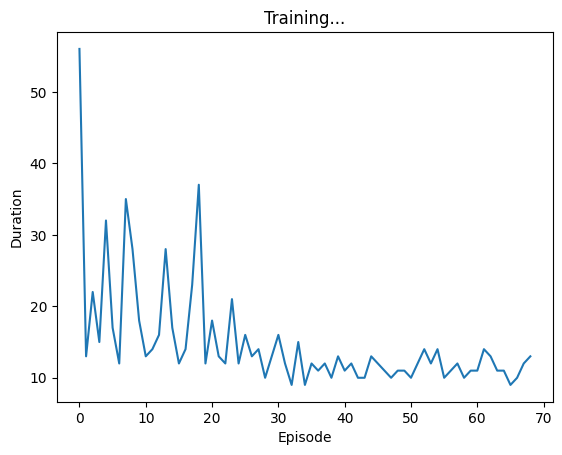

In [11]:
#for training new model, model saved to file after reaching 500 duration

if torch.cuda.is_available():
    num_episodes=600
else:
    num_episodes = 50
    
for i_episode in range(num_episodes):
    state, info = env.reset()
    env.render()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        print(action)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated
        
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        
        memory.push(state, action, next_state, reward)
        state=next_state
        optimize_model()
        
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU+target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)
        if len(episode_durations) and (episode_durations[-1] ==500):
            torch.save(target_net_state_dict, 'cart_pole_weights.pt')
        if done:
            episode_durations.append(t+1)
            plot_durations()
            break
print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

In [6]:
import json

if torch.cuda.is_available():
    num_episodes=600
else:
    num_episodes = 50
target_net_state_dict = None
target_net_state_dict=torch.load('cart_pole_weights.pt')
target_net.load_state_dict(target_net_state_dict)
policy_net.load_state_dict(target_net_state_dict)
for i_episode in range(num_episodes):
    state, info = env.reset()
    env.render()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action_pretrained(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated
        
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        
        memory.push(state, action, next_state, reward)
        state=next_state
          
        
        if done:
            episode_durations.append(t+1)
            plot_durations()
            break
print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>